In [1]:
# The Power Pattern Challenge
# Team: [Redacted]

In [2]:
# ONLY RUN THIS CELL ONCE
# !pip install -r requirements.txt

In [3]:
# importaing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from utils import calculate_average_hourly_energy_consumption, add_building_tags, normalize_df, get_building_tag_values, fit_kshape_clustering, plot_kshape_clustering
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from joblib import dump, load

### Overall introduction to the clustering pipeline design
For this challenge, we adopt a two-stage clustering pipeline, where the first stage generates representations of buildings with a reduced size of dimensionality compared with the original, 365-day-long load curve, and the second stage conducts clustering on the reduced representations. 

- In the first stage, we cluster the entire daily-load-curve dataset of all buildings with a simple and straightforward k-means algorithm (with N_1 clusters). After applying the k-means model to each building, a daily allocation result of 365 days is obtained. For simplicity and clarity, we calculate the proportions of daily load curves allocated to each cluster within each season, resulting in a load profile representation of the size N_1 * 4 for each building.

- In the second stage, we use spectral clustering (with N_2 clusters) algorithm to cluster the buildings and try to obtain meaningful customer groups that are useful for demand response programs.

Such a two-stage clustering pipeline can be useful because more information related to the dynamic characteristics of the buildings' electricity consumption patterns can be preserved and compared. 

### Set global variables for reproducibility
For the sake of reproducibility, we define two variables, namely, TRAIN_STAGE1, and TRAIN_STAGE2 as follows:

* TRAIN_STAGE1: train the k-means clustering model of the first stage when set to True. Load the trained k-means model when set to False.
* TRAIN_STAGE2: train the spectral clustering model of the second stage when set to True. Load the trained and predicted labels when set to False.

For now, we set both variables to False so that the results produced by the notebook can be reproduced.

In [4]:
# In order to reproduce the results, set TRAIN_STAGE1 and TRAIN_STAGE2 to False
TRAIN_STAGE1 = False
TRAIN_STAGE2 = False

### Data preparation
Before jumping into the clustering algorithms, we first load the data of the buildings and make some simple preparations. As the original data has a 15-minute interval, we need to transform the data into hourly electricity consumption series.

In [6]:
# Load data from files (the ./data folder is needed, please help put the data of the buildings in this folder)
load_folderpath = os.getcwd() + '/data'

files_list = os.listdir(load_folderpath)
dfs = []

for file_name in tqdm(files_list):
    file_path = f'{load_folderpath}/{file_name}'
    df = pd.read_parquet(file_path, engine='pyarrow')
    dfs.append(df)

100%|█████████████████████████████████████████████████████████████████████████████| 1277/1277 [00:06<00:00, 195.65it/s]


In [7]:
# Process the data and turn 15-minite consumption values to hourly consumption values
days = 365
consumptions = []
for df in tqdm(dfs):
    df_ = df.reset_index()
    bldg_id = df_.iloc[0].bldg_id
    for i in range(days):
        start, end = i * 96, (i + 1) * 96
        consumption_ = df_.iloc[start: end]['out.electricity.total.energy_consumption'].values.reshape((24, 4))
        consumption_ = np.sum(consumption_, axis=1)
        consumption = consumption_.copy()
        consumptions.append(consumption)

100%|██████████████████████████████████████████████████████████████████████████████| 1277/1277 [00:20<00:00, 63.21it/s]


### Baseline solution
Next, we use the clustering method in the starter notebook provided by the hosts as a simple baseline. Despite its simplicity, the baseline method is representative and easy to follow as well. Calculating the mean profile within different seasons and find clusters based on the profiles is definitely a good starting point, as it echos the target of demand response programs that are directly designed to operate on mean profiles of customers.

In [8]:
# Generate the 72-feature representations of buildings based on average hourly energy consumptions
data_folder_path = os.getcwd() + '/data'
season_months_dict = {'cold': [1, 2, 12], 'hot': [6, 7, 8], 'mild': [3, 4, 5, 9, 10, 11]}
df = calculate_average_hourly_energy_consumption(folder_path = data_folder_path,
                                                 season_months_dict = season_months_dict)

E:\Lab\onward\profile\submissions\0524\utils.py:153: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_normalized = df1.div(df.groupby(axis=1, level=0).transform('max'), axis=0)


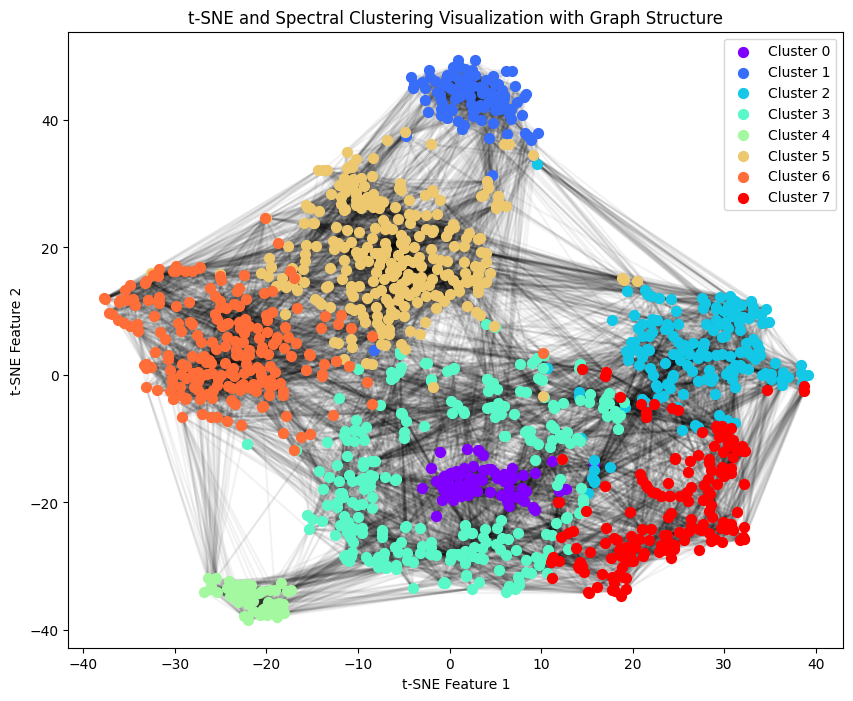

In [9]:
# Normalize data within season
df_normalized = normalize_df(df, normalize='within_season')
data = df_normalized.values.copy()

# Use spectral clustering with the number of clusters set to 8
n_clusters = 8
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0, n_neighbors=10)
cluster_labels = spectral.fit_predict(data)

# Use t-SNE for data visualization
tsne = TSNE(n_components=2, random_state=0)
transformed_data = tsne.fit_transform(data)

# Use kneighbors_graph with n_neighbors set to 40 for graph connection visualization
plt.figure(figsize=(10, 8))
connectivity = kneighbors_graph(data, n_neighbors=40, include_self=False)
connectivity = connectivity.toarray()
for i in range(transformed_data.shape[0]):
    for j in range(i+1, transformed_data.shape[0]):
        if connectivity[i, j] > 0:
            plt.plot([transformed_data[i, 0], transformed_data[j, 0]],
                     [transformed_data[i, 1], transformed_data[j, 1]], 'k-', alpha=0.05, zorder=1)

# Plot cluster labels with specifically assigned colors and graph connections
unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE and Spectral Clustering Visualization with Graph Structure')
plt.legend(loc='best')
plt.show()

We can see from the above figure that:
- The clusters in general do not have visible borders
- Some hidden data structures are not easy to describe under the baseline method, such as the relationship between cluster 0 and cluster 3 (the samples of cluster 3 surrounds cluster 1). Although the dimensionality algorithm of t-SNE is non-linear, we can still observe the level of complexity within the data based on the connectivities among the clusters (the lines in black).
 
We continue to plot the aggregate consumptions of the clusters hereafter.

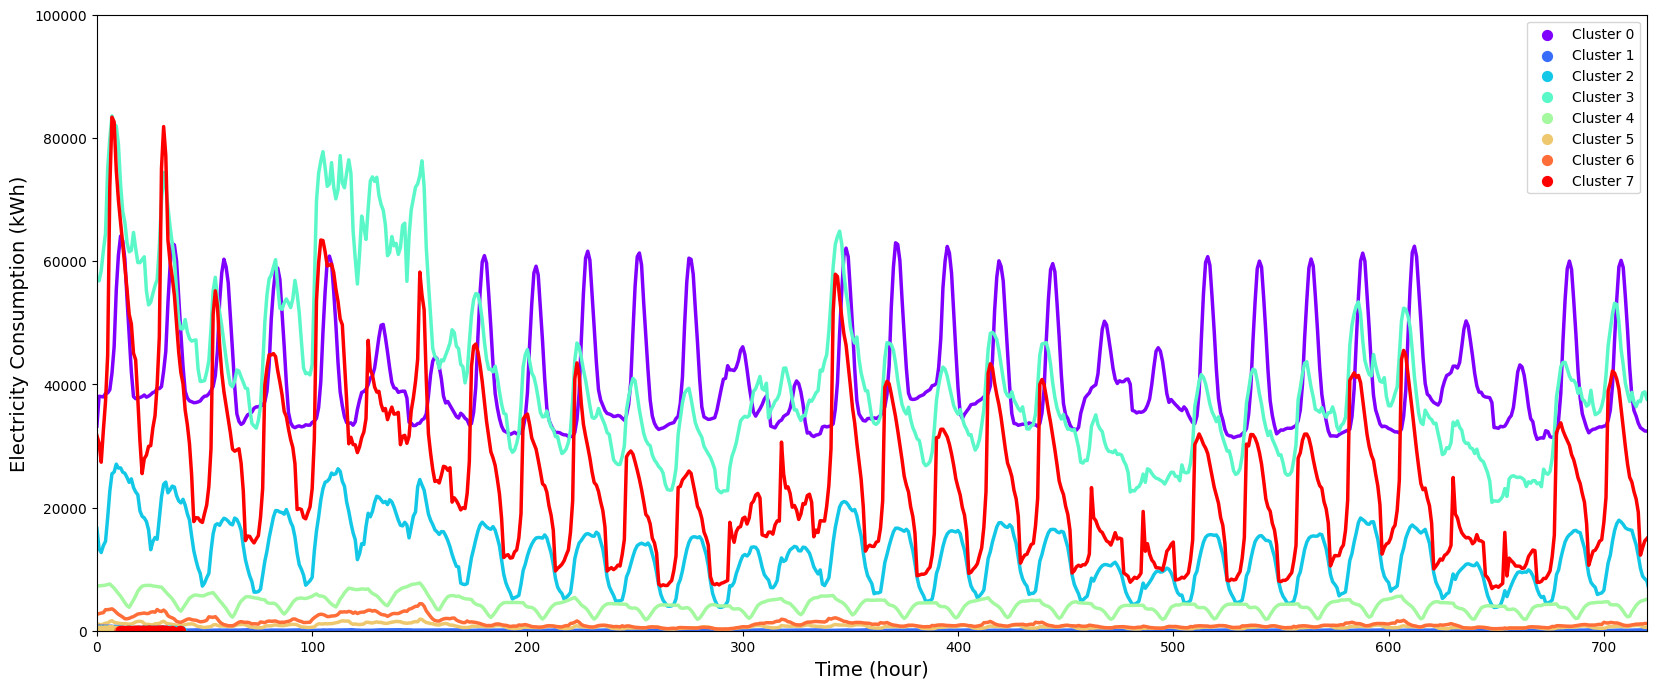

In [10]:
# Plot the aggregate electricity consumption curves of the clusters in the first 30 days of the year
consumptions_array = np.array(consumptions).reshape(1277, 365, 24)

plt.figure(figsize=(20, 8))
for i in range(8):
    plt.plot(consumptions_array[cluster_labels == i].sum(0).reshape(-1,), color=colors[i], linewidth=2.5)
plt.axis([0, 30 * 24, 0, 100000])
plt.xlabel('Time (hour)', fontsize=14)
plt.ylabel('Electricity Consumption (kWh)', fontsize=14)

unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)
plt.legend(loc='best')

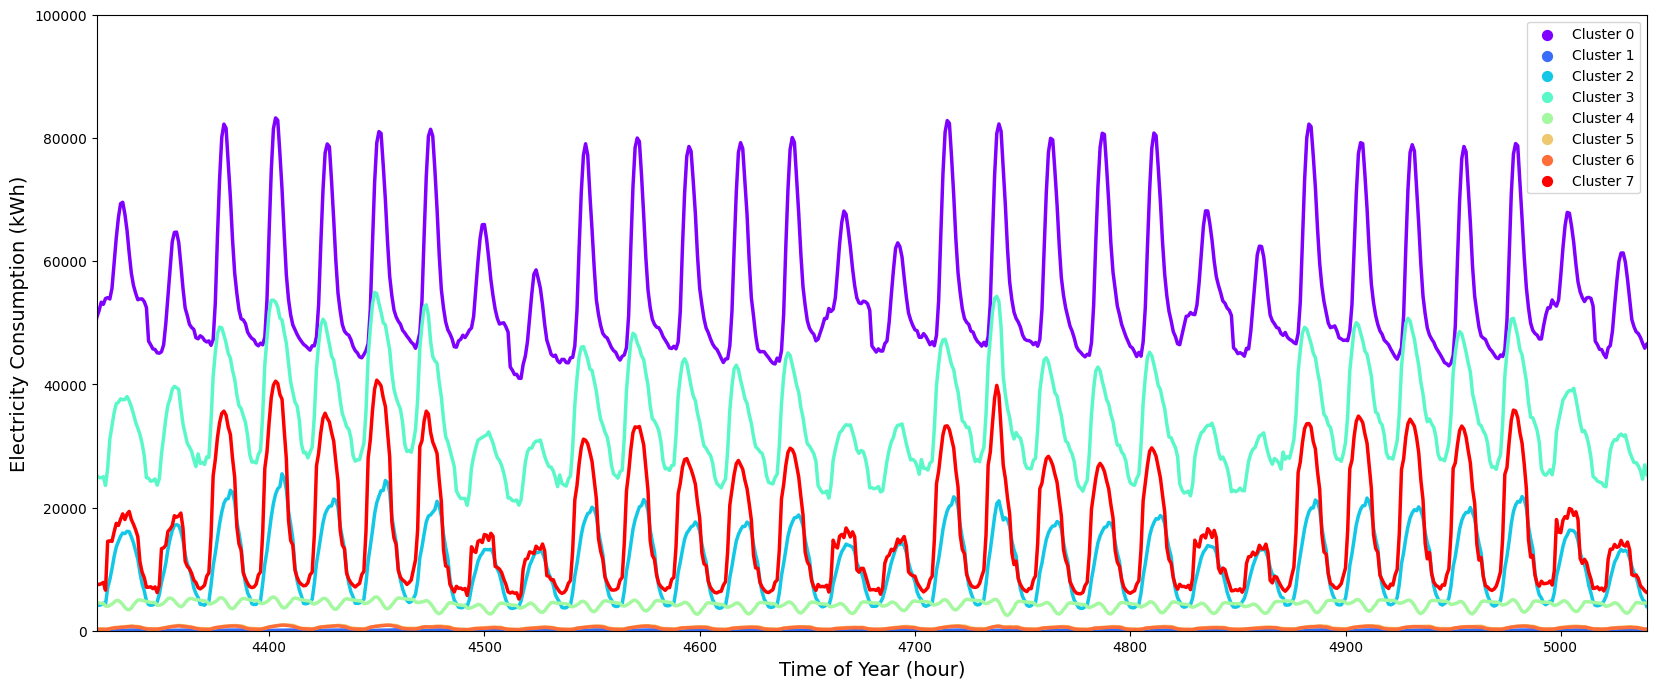

In [11]:
# Plot the aggregate electricity consumption curves of the clusters from the 180th to the 210th days of the year
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.plot(consumptions_array[cluster_labels == i].sum(0).reshape(-1,), color=colors[i], linewidth=2.5)
plt.axis([180 * 24, 180 * 24 + 30 * 24, 0, 100000])
plt.xlabel('Time of Year (hour)', fontsize=14)
plt.ylabel('Electricity Consumption (kWh)', fontsize=14)

unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)
plt.legend(loc='best')

It can be seen from the above figures that:
- Apart from cluster 1 (the cluster with the lowest consumption), the aggregate consumptions of cluster 5 and 6 are also quite low.
- The characteristics of the relatively high-consumption clusters are not very distinguishable (e.g., cluster 2 and 7 during weekends in the summer plot). This may or may not be a problem with the clustering pipeline, but we'd better keep an eye on it as this would greatly affect the effectiveness of the demand response program.

We now proceed to build the two-stage clustering pipeline as follows.

### Stage one: representation generation
In the first stage, we use a simple k-means clustering method to find the fundamentall <i> local </i> structures within the dataset. While the daily load curves of all customers or buildings are messy, a simple clustering method can help us put the curves into groups. Representations of customers or buildings can be created on top of that.

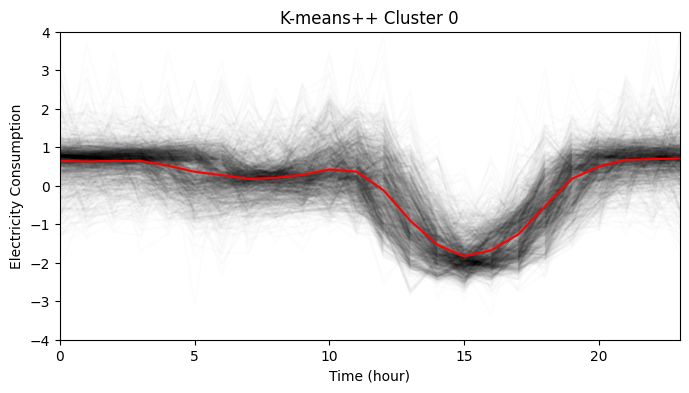

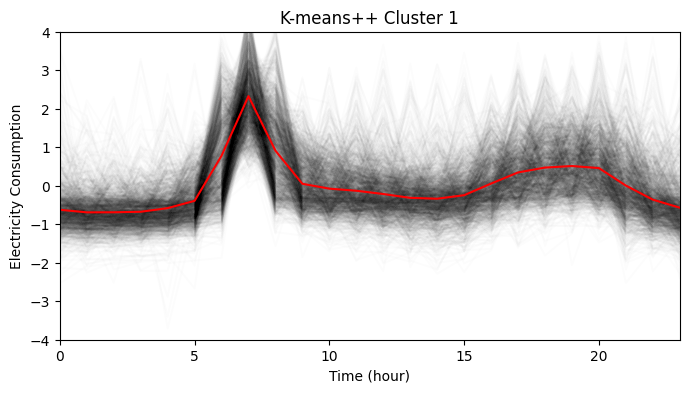

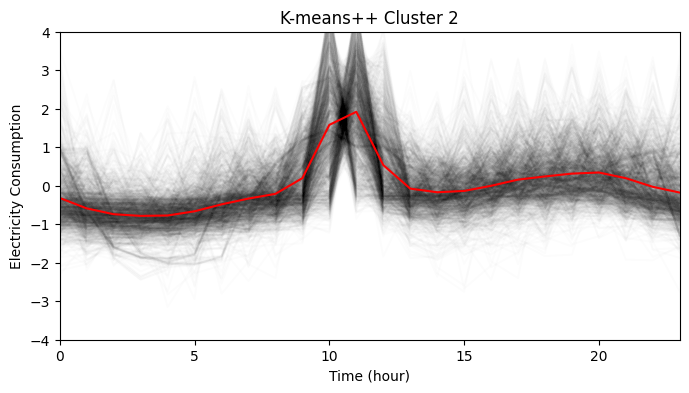

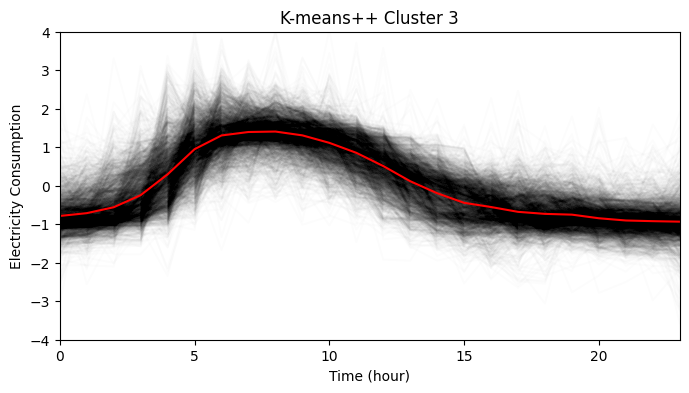

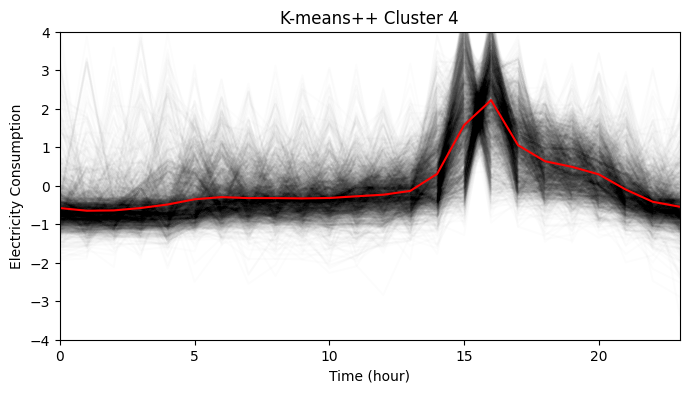

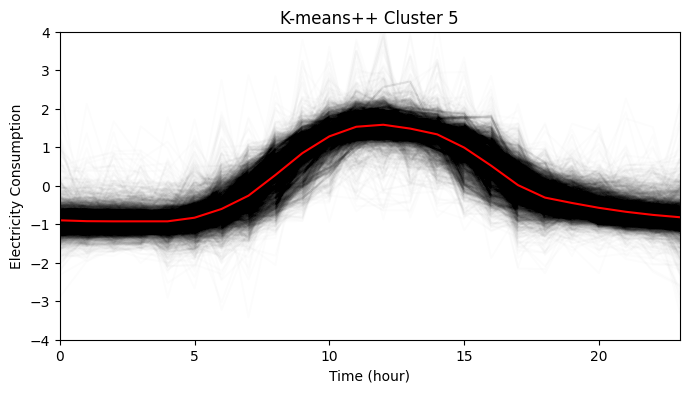

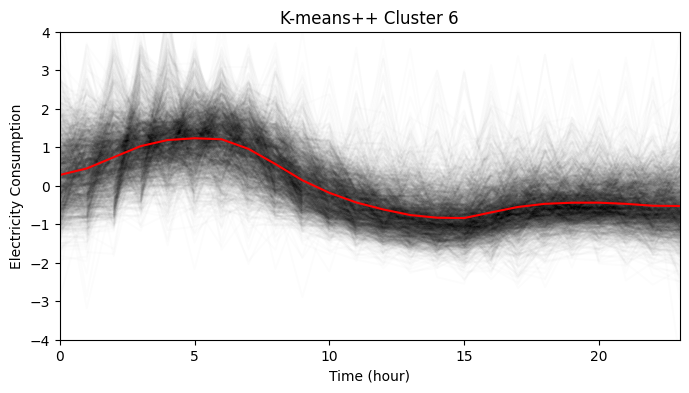

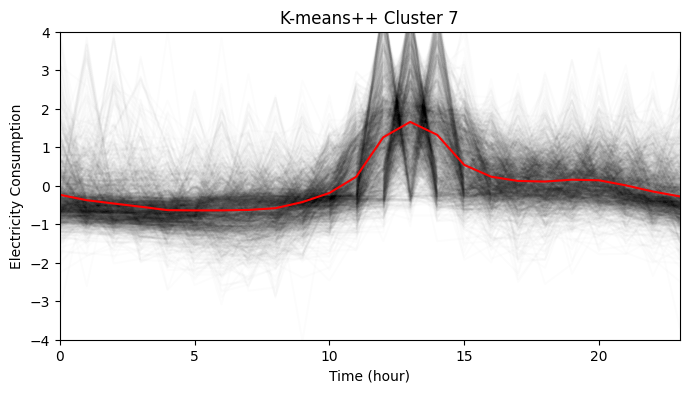

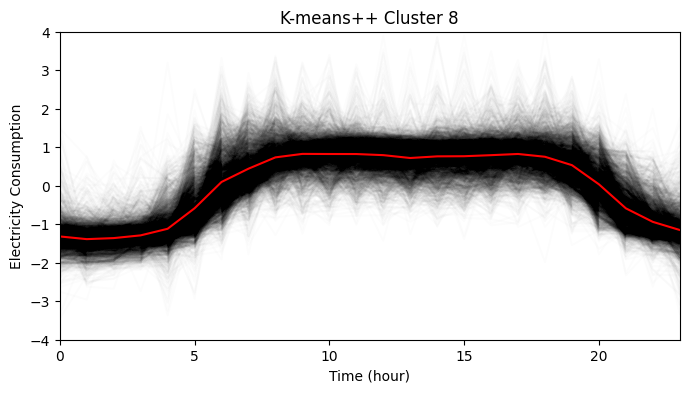

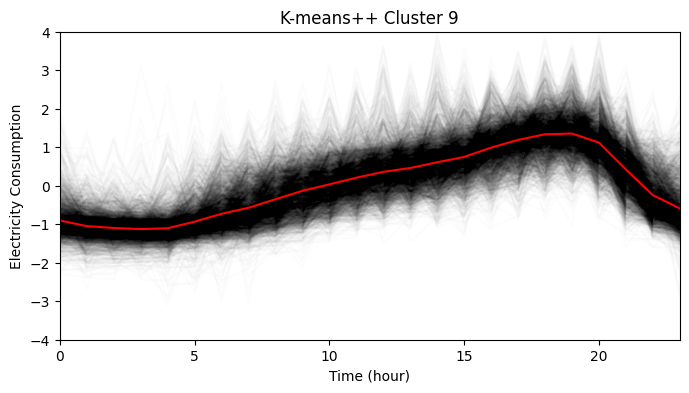

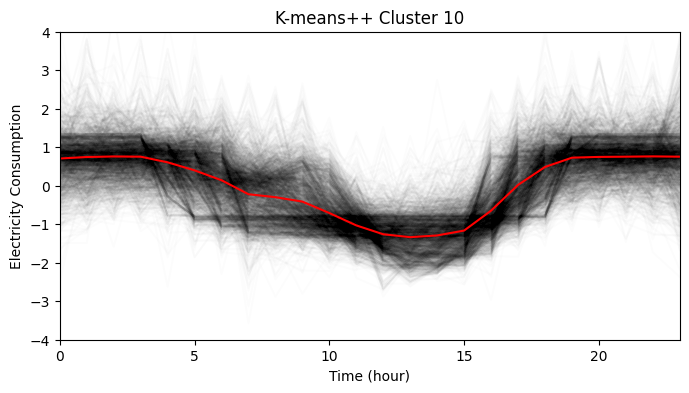

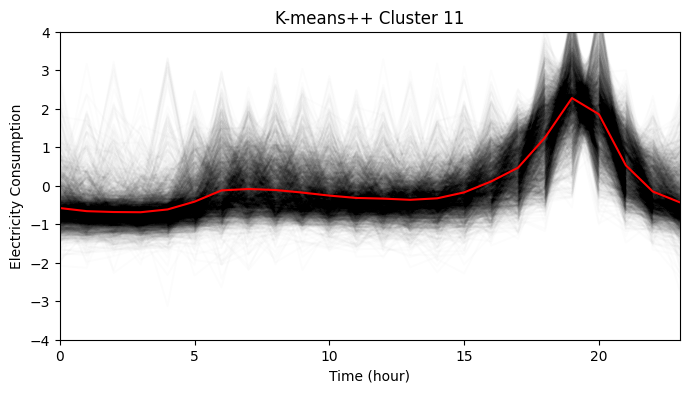

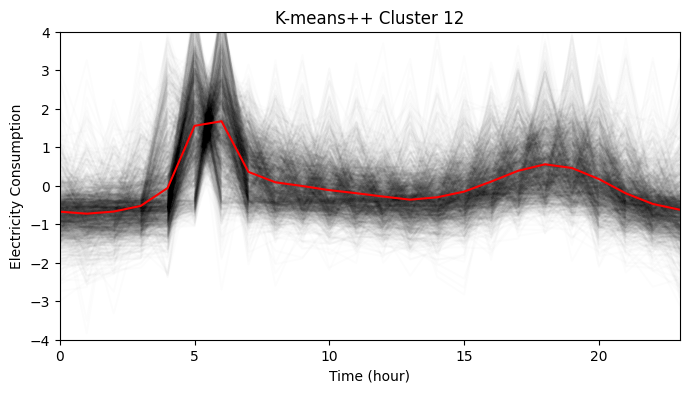

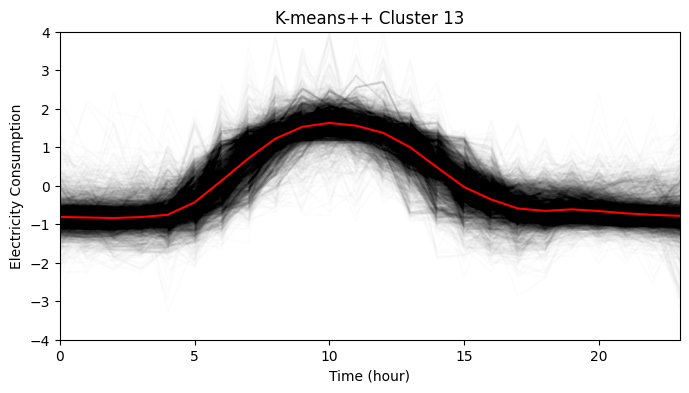

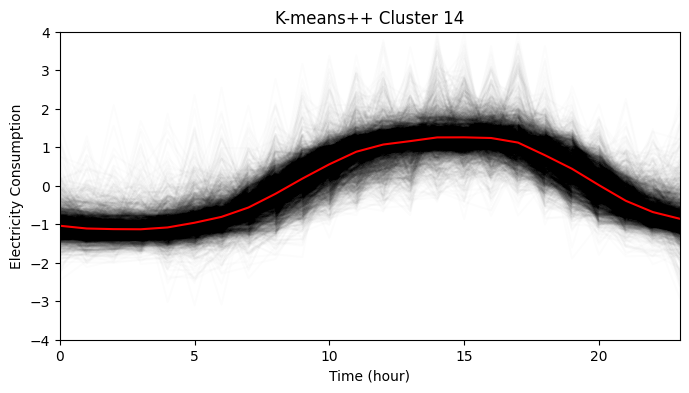

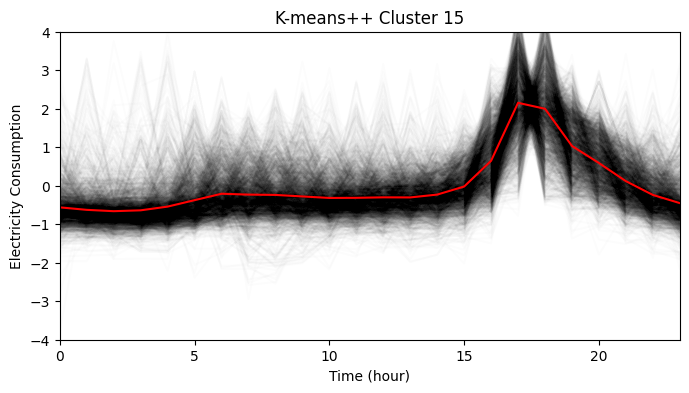

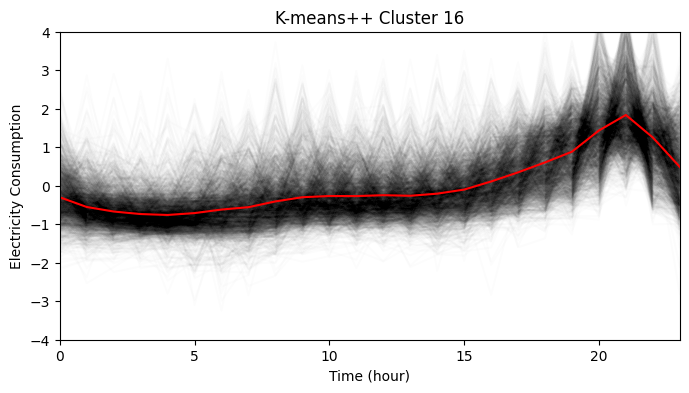

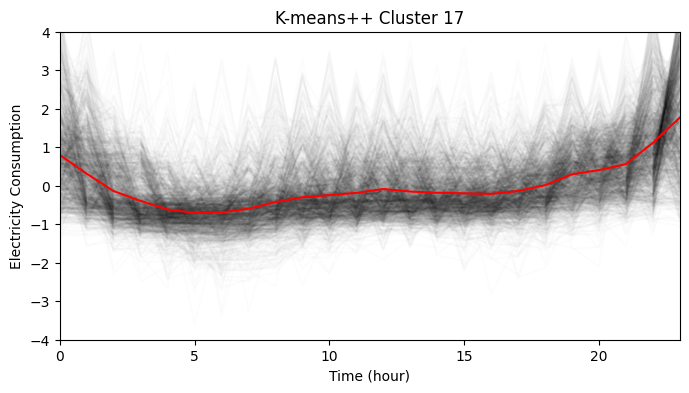

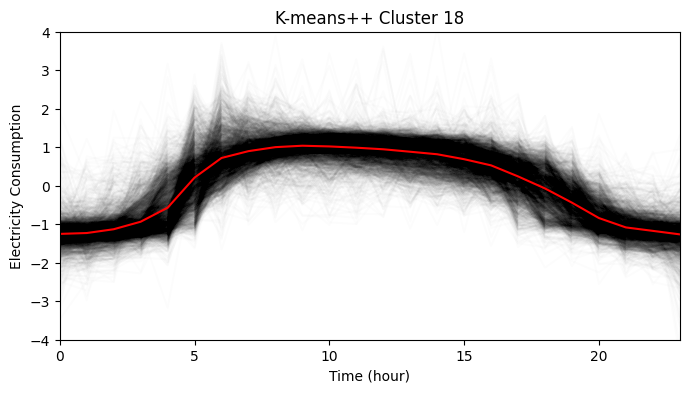

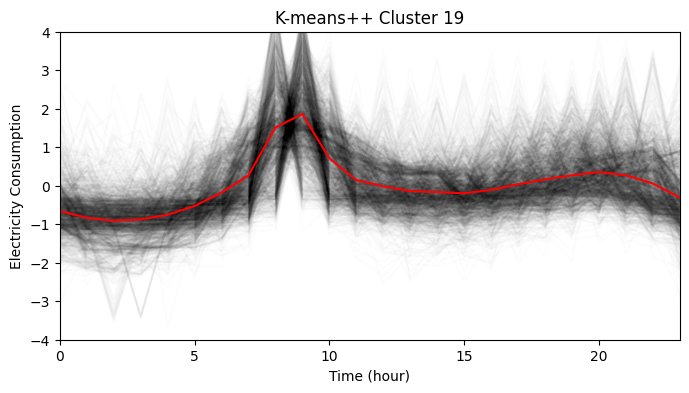

In [12]:
# Scale the load curves so that the series have zero mean and unit std
consumptions_scaled = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(consumptions)

# Use TimeSeriesKMeans for the clustering of daily load curves, the metric is the default, "euclidean" 
# The number of clusters is set to 20 to cover more unique patterns.
n_clusters = 20
if TRAIN_STAGE1:
    best_km = TimeSeriesKMeans(n_clusters=n_clusters, n_init=4, n_jobs=-1, tol=1e-4, verbose=True, random_state=0, init='k-means++')
    y_pred = best_km.fit_predict(consumptions_scaled)
else:
    best_km = load('./models/kmeans_model_step1_20_v1.joblib')
    y_pred = best_km.predict(consumptions_scaled)

# Plot the cluster centers and load curves assigned to the clusters
for yi in range(n_clusters):
    plt.figure(figsize=(8, 4))
    for ii, xx in enumerate(consumptions_scaled[y_pred == yi]):
        if ii % 10 == 0:
            plt.plot(xx.ravel(), "k-", alpha=0.01)
    plt.plot(best_km.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"K-means++ Cluster {yi}")
    plt.xlim(0, len(consumptions_scaled[0]) - 1)
    plt.ylim(-4, 4)
    plt.xlabel('Time (hour)')
    plt.ylabel('Electricity Consumption')
    plt.show()

There is high diversity in the clusters illustrated in the figures above, and for some clusters with spikes we can clearly see that there are actually spikes within adjacent (but separate) hours (e.g., cluster 1, 2, 4, 7, 11, 12, 15, 16, and 19). We find it totally fine as the hourly data granularity limits the resolution we can possibly have.

In [13]:
# Generate the cluster asssignment array
cluster_assignments = []
for i in tqdm(range(365)):
    cluster_assignment = []
    for j in range(1277):
        assignment = y_pred[j * 365 + i]
        cluster_assignment.append(assignment)
    cluster_assignments.append(cluster_assignment)
cluster_assignments_array = np.array(cluster_assignments)

100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 3964.01it/s]


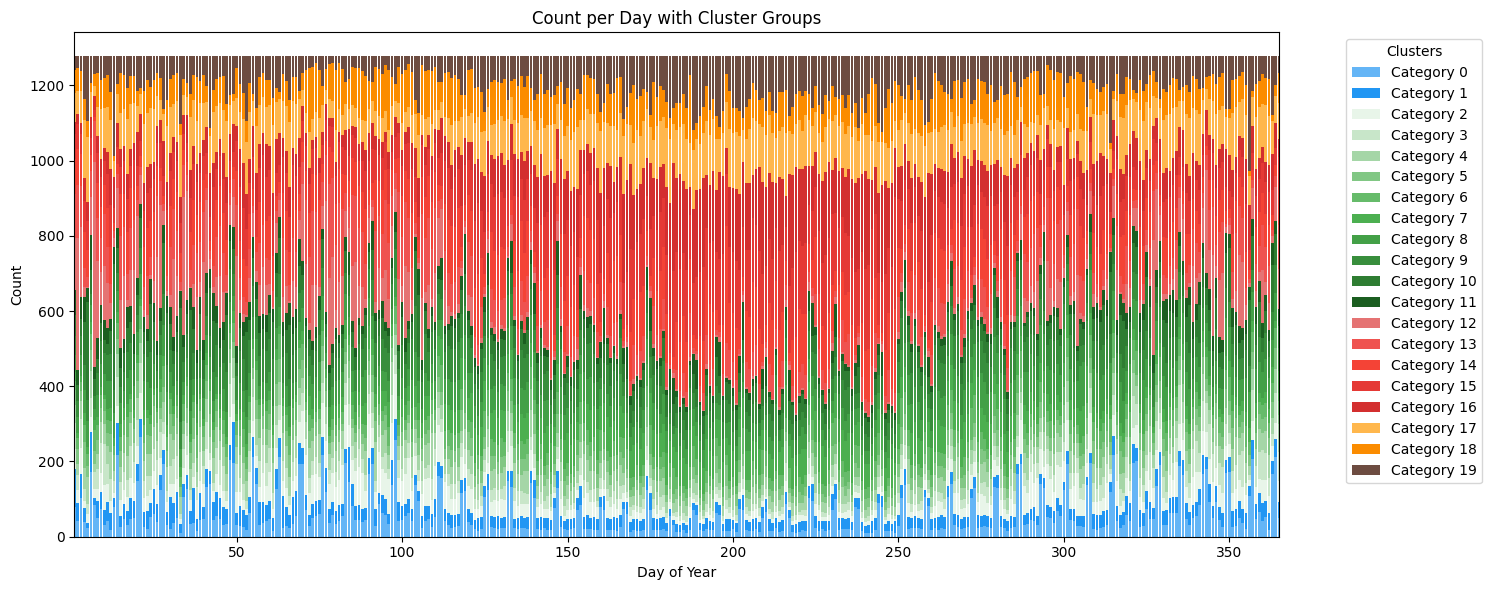

In [14]:
# Here we re-arrange the clusters according to the shapes of the profiles, described as follows:
# Cluster 10 and 0: valley
# Cluster 12, 1, 19, 2, 7, 4, 15, 11, 16, and 17: spike
# Cluster 6, 3, 13, 5, 14: mild peak
# Cluster 8 and 18: a flat plate in the middle 
# Cluster 9: a slow upward trend and drops at the end
remap_dict = {
    0: 1,
    1: 3,
    2: 5,
    3: 13,
    4: 7,
    5: 15,
    6: 12,
    7: 6,
    8: 17,
    9: 19,
    10: 0,
    11: 9,
    12: 2,
    13: 14,
    14: 16,
    15: 8,
    16: 10,
    17: 11,
    18: 18,
    19: 4,
}
data = cluster_assignments_array.copy()

for old_id, new_id in remap_dict.items():
    data[data == old_id] = new_id + 100
data -= 100

# Allocate colors to different profile groups
colors = ['#64B5F6', '#2196F3',
          '#E8F5E9', '#C8E6C9', '#A5D6A7', '#81C784', '#66BB6A', '#4CAF50', '#43A047', '#388E3C', '#2E7D32', '#1B5E20',
          '#E57373', '#EF5350', '#F44336', '#E53935', '#D32F2F',
          '#FFB74D', '#FB8C00',
          '#6D4C41']

category_counts = np.zeros((365, 20), dtype=int)
for i in range(20):
    category_counts[:, i] = np.sum(data == i, axis=1)

# Plot the proportion of profile groups across the year
plt.figure(figsize=(15, 6))
bottoms = np.zeros(365)
for i in range(20):
    plt.bar(range(1, 366), category_counts[:, i], bottom=bottoms, label=f'Category {i}', color=colors[i])
    bottoms += category_counts[:, i]

plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('Count per Day with Cluster Groups')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(1, 365)
plt.tight_layout()
plt.show()

We can see from the figure above that the proportions of the cluster groups are quite stable but yearly and weekly seasonality do exist. For the next step, we split the year into four seasons and calculate the proportions within seasons for each customer or building, producing a 4*20=80 dimensional representation for each one of them.

In [15]:
# Generate the date ranges for each season in the year 2018
date_range = pd.date_range(start='2018-01-01', end='2018-12-31')

def get_season(month):
    if month in [1, 2, 12]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df = pd.DataFrame(date_range, columns=["date"])
df["season"] = df["date"].dt.month.apply(get_season)

spring_dates = df[df["season"] == "Spring"]["date"]
summer_dates = df[df["season"] == "Summer"]["date"]
autumn_dates = df[df["season"] == "Autumn"]["date"]
winter_dates = df[df["season"] == "Winter"]["date"]

spring_index = spring_dates.index.tolist()
summer_index = summer_dates.index.tolist()
autumn_index = autumn_dates.index.tolist()
winter_index = winter_dates.index.tolist()

In [16]:
# For each customer or building, calculate the proportions of days assigned to each cluster for each season
cluster_proportions = []
for i in tqdm(range(1277)):
    cluster_proportion = np.zeros((4, 20))
    for j in range(365):
        if j in spring_index:
            cluster_proportion[0, cluster_assignments_array[j, i]] += 1
        if j in summer_index:
            cluster_proportion[1, cluster_assignments_array[j, i]] += 1
        if j in autumn_index:
            cluster_proportion[2, cluster_assignments_array[j, i]] += 1
        if j in winter_index:
            cluster_proportion[3, cluster_assignments_array[j, i]] += 1
    cluster_proportion[0] = cluster_proportion[0] / len(spring_index)
    cluster_proportion[1] = cluster_proportion[1] / len(summer_index)
    cluster_proportion[2] = cluster_proportion[2] / len(autumn_index)
    cluster_proportion[3] = cluster_proportion[3] / len(winter_index)
    cluster_proportions.append(cluster_proportion)

100%|████████████████████████████████████████████████████████████████████████████| 1277/1277 [00:01<00:00, 1126.10it/s]


### Stage two: spectral clustering on the representations
In stage two, spectral clustering is selected to cluster the buildings into groups that are supposed to have characteristic load consumption patterns when aggregated. The major reason behind this choice is that spectral clustering is by nature considering the graph structure describing the similarities among the representations we have constructed in stage one, which would help us better interpret the clustering results.

In [17]:
# Prepare the representations of the customers or buildings
cluster_proportions_array = np.array(cluster_proportions)
cluster_proportions_x = cluster_proportions_array.reshape(-1, 20 * 4)

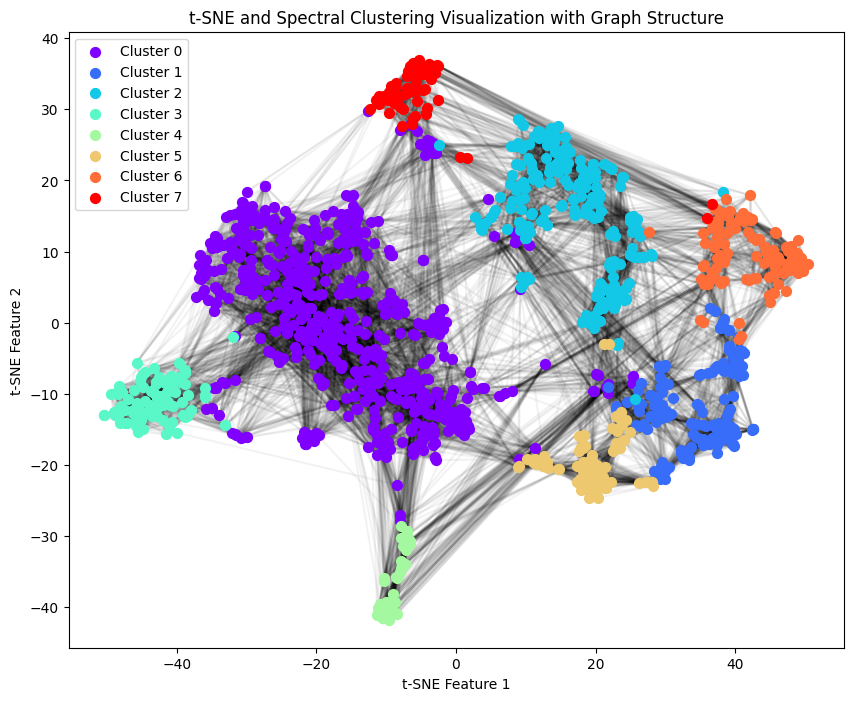

In [18]:
# Copy the variable
data = cluster_proportions_x.copy()

# Use spectral clustering with the number of clusters set to 8
n_clusters = 8
if TRAIN_STAGE2:
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0, n_neighbors=10)
    cluster_labels = spectral.fit_predict(data)
else:
    spectral = load('./models/spectral_model_8_v1.joblib')
    cluster_labels = spectral.labels_

# Use t-SNE for data visualization
tsne = TSNE(n_components=2, random_state=0)
transformed_data = tsne.fit_transform(data)

# Plot cluster labels with specifically assigned colors and graph connections
plt.figure(figsize=(10, 8))
connectivity = kneighbors_graph(data, n_neighbors=40, include_self=False)
connectivity = connectivity.toarray()
for i in range(transformed_data.shape[0]):
    for j in range(i+1, transformed_data.shape[0]):
        if connectivity[i, j] > 0:
            plt.plot([transformed_data[i, 0], transformed_data[j, 0]],
                     [transformed_data[i, 1], transformed_data[j, 1]], 'k-', alpha=0.05, zorder=1)

unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE and Spectral Clustering Visualization with Graph Structure')
plt.legend(loc='best')
plt.show()

By comparing the clustering result with the baseline, we can clearly see that the proposed method creates representations that are more distinguishable and that the clusters are more compact after t-SNE visualization. We proceed to plot the aggregate consumption time series of the clusters.

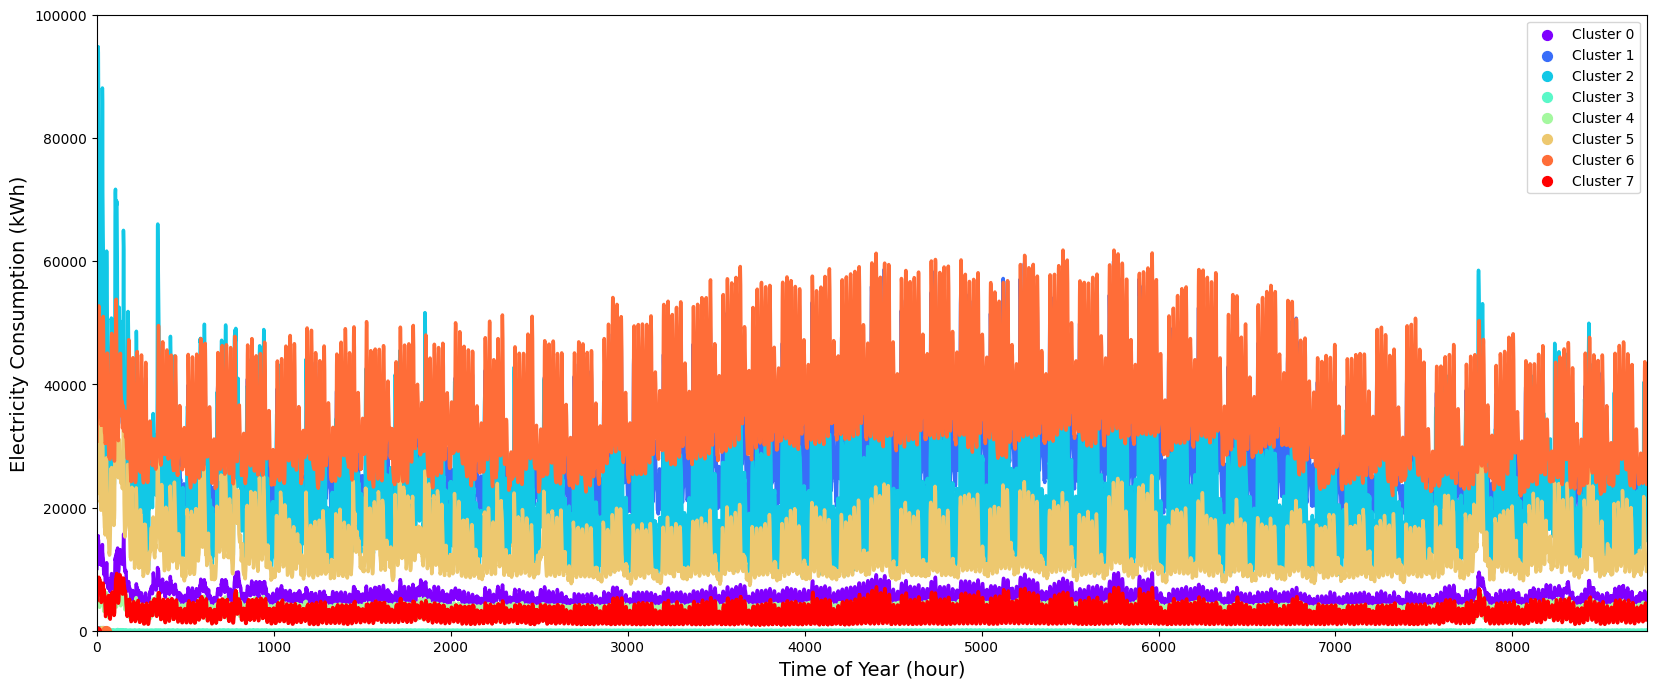

In [19]:
# Plot the total consumption time series for each cluster in the second stage in a single plot
consumptions_array = np.array(consumptions).reshape(1277, 365, 24)

plt.figure(figsize=(20, 8))
for i in range(8):
    plt.plot(consumptions_array[cluster_labels == i].sum(0).reshape(-1,), color=colors[i], linewidth=2.5)
plt.axis([0, 365 * 24, 0, 100000])
plt.xlabel('Time of Year (hour)', fontsize=14)
plt.ylabel('Electricity Consumption (kWh)', fontsize=14)

unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[0, 0], xy[0, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)
plt.legend(loc='best')

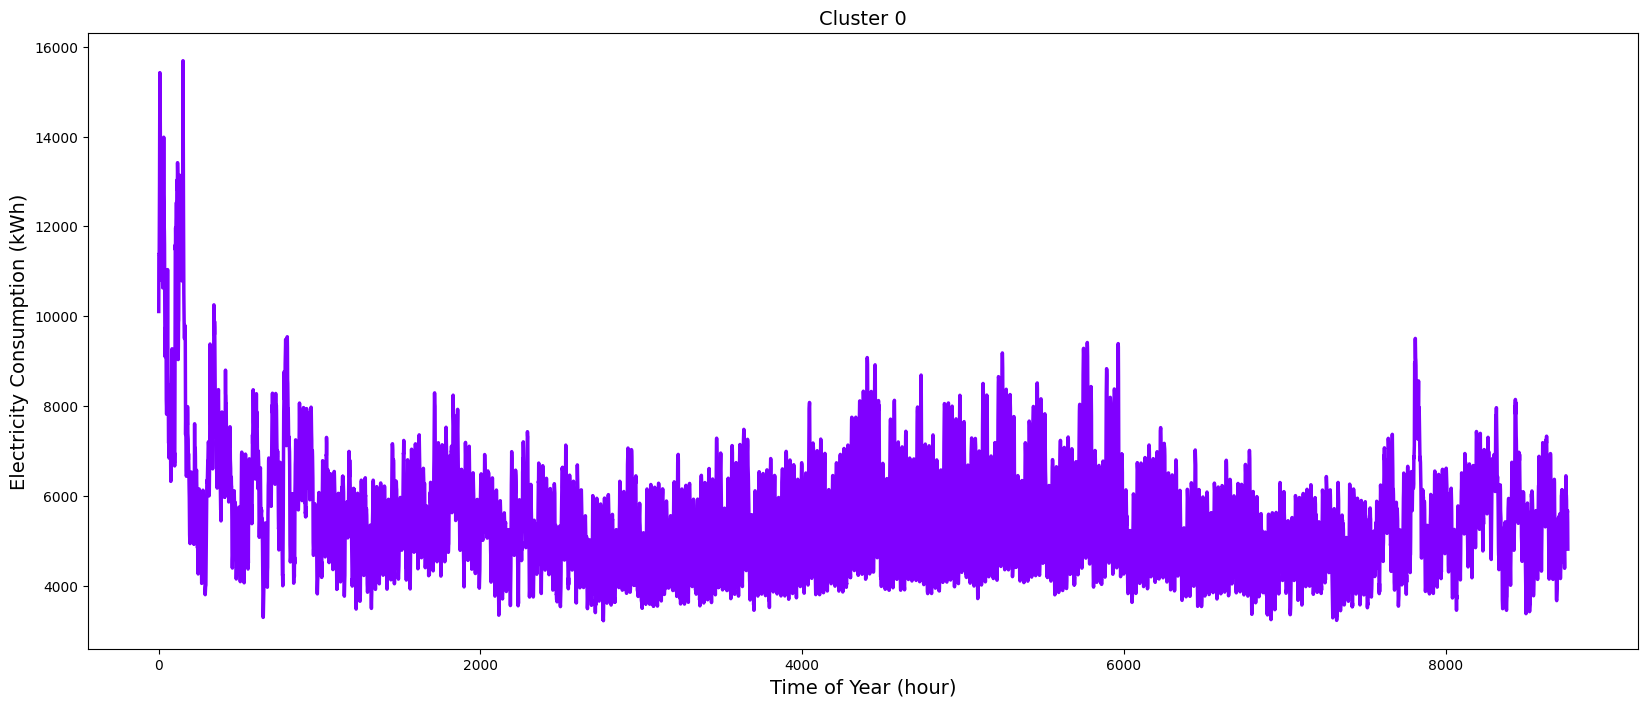

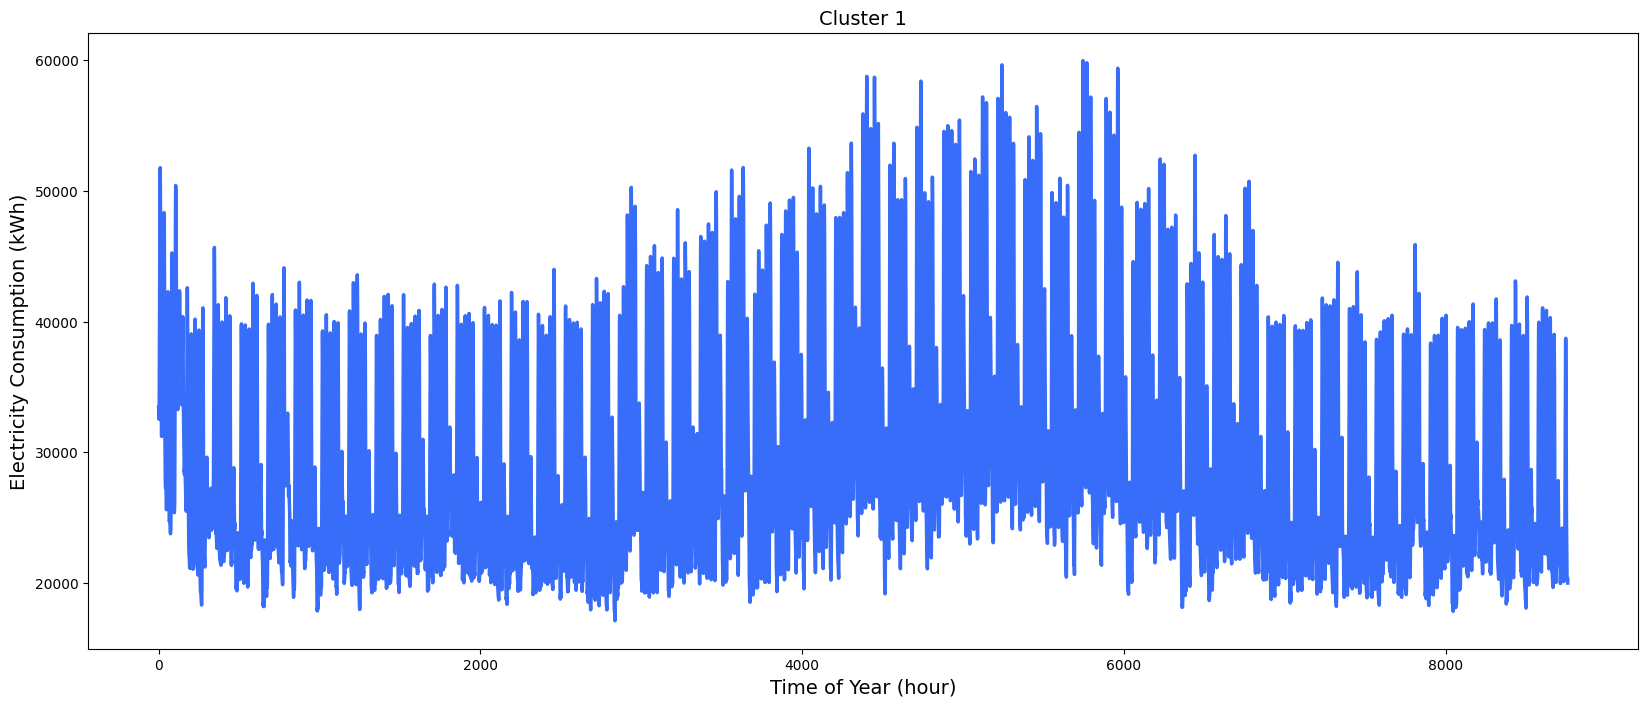

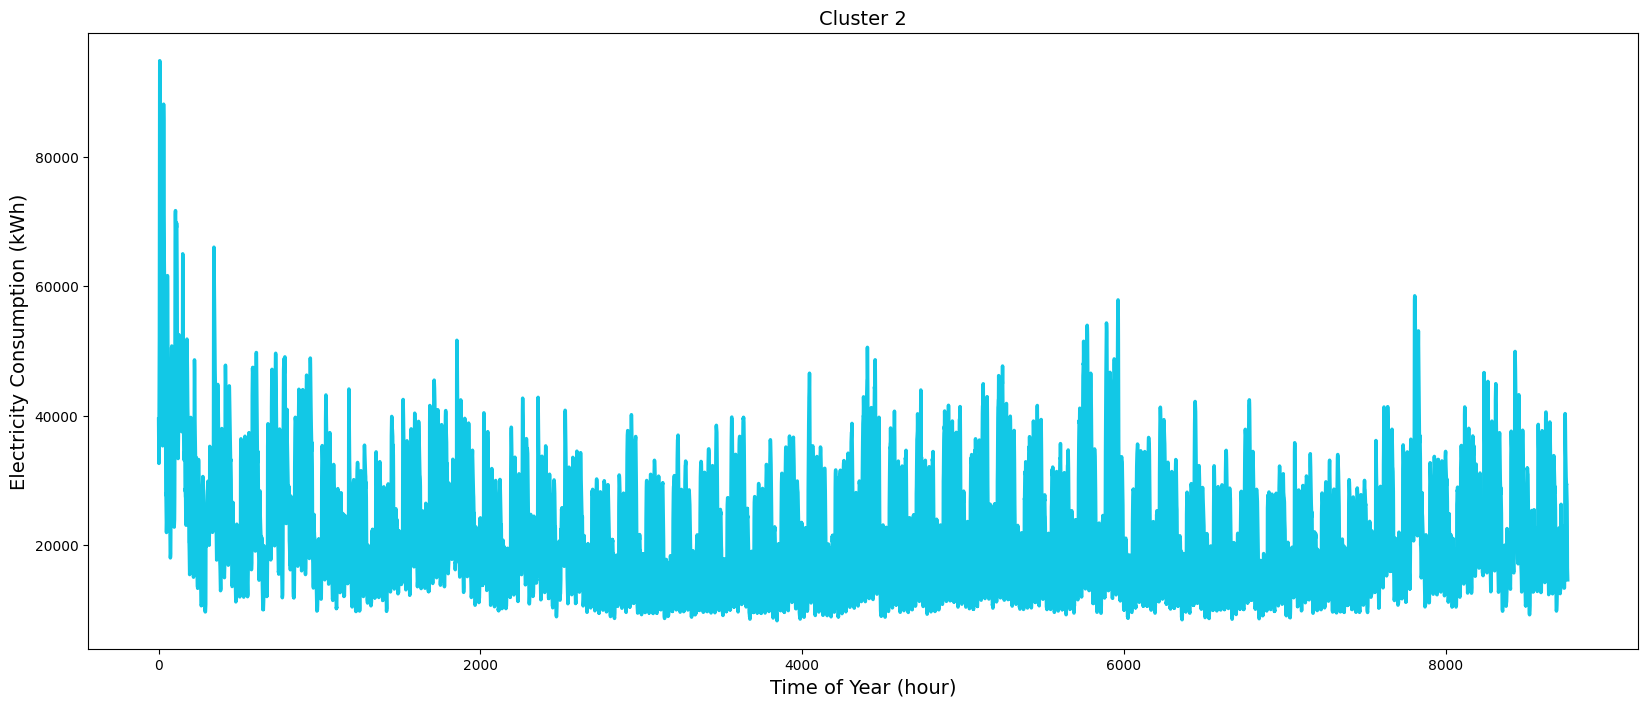

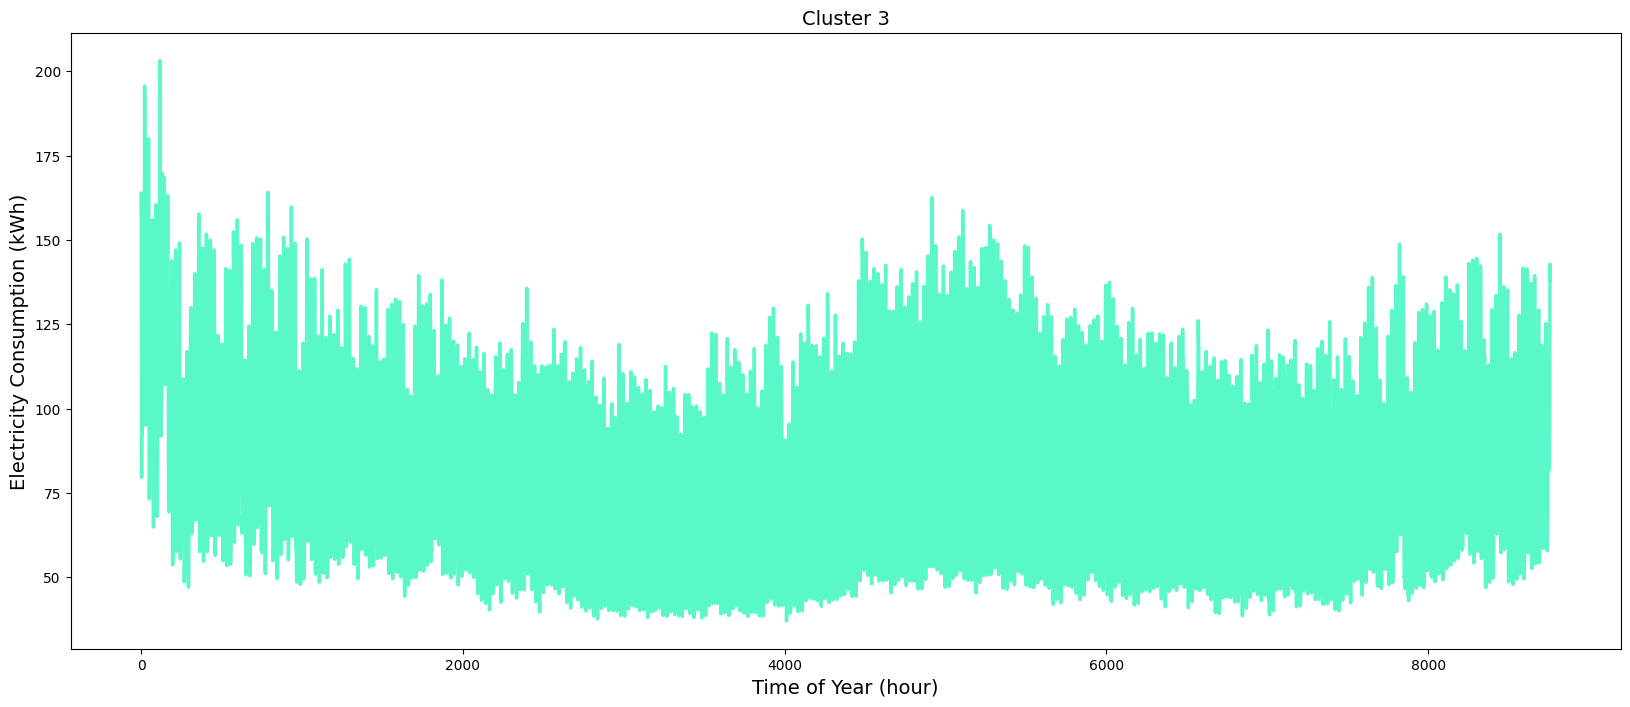

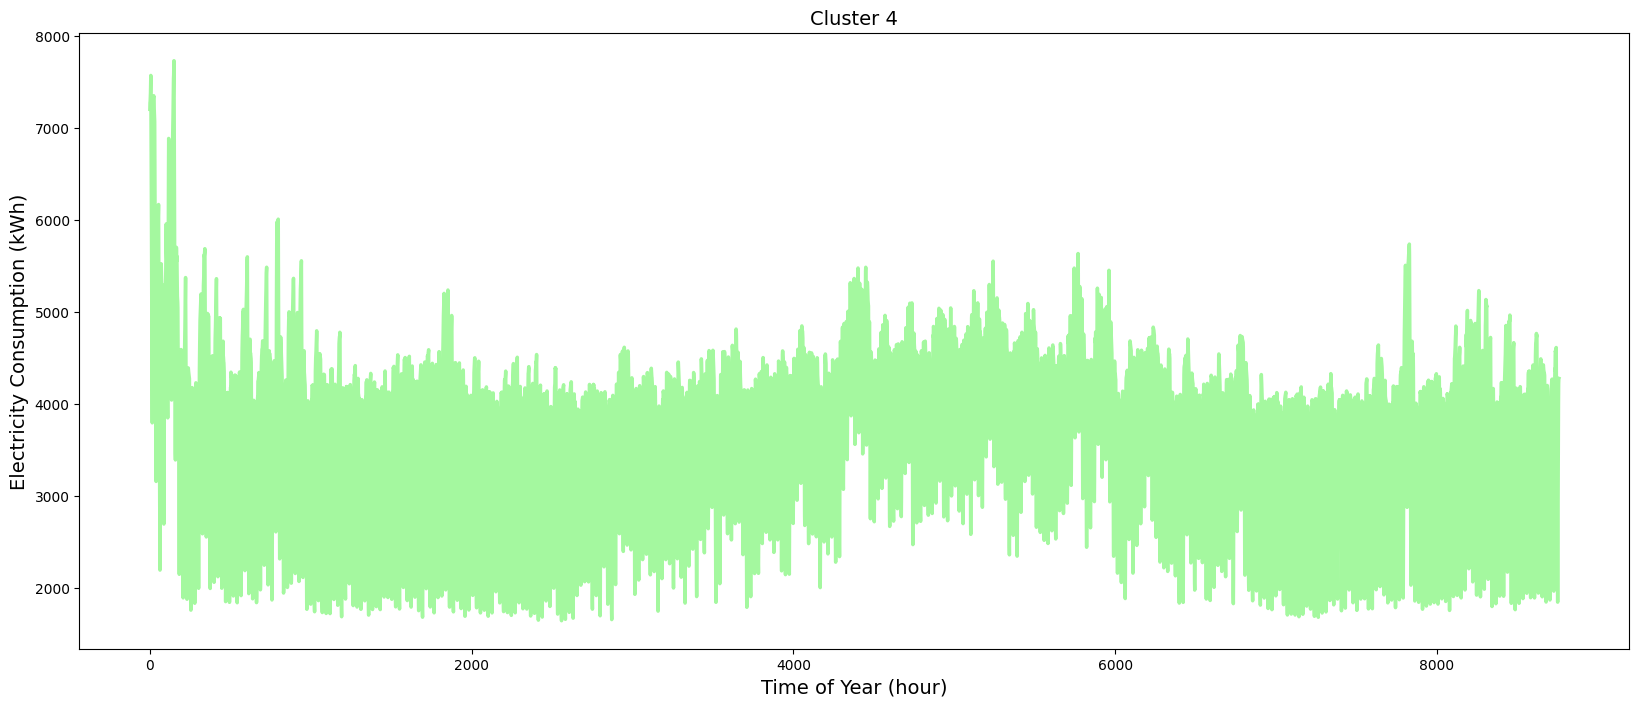

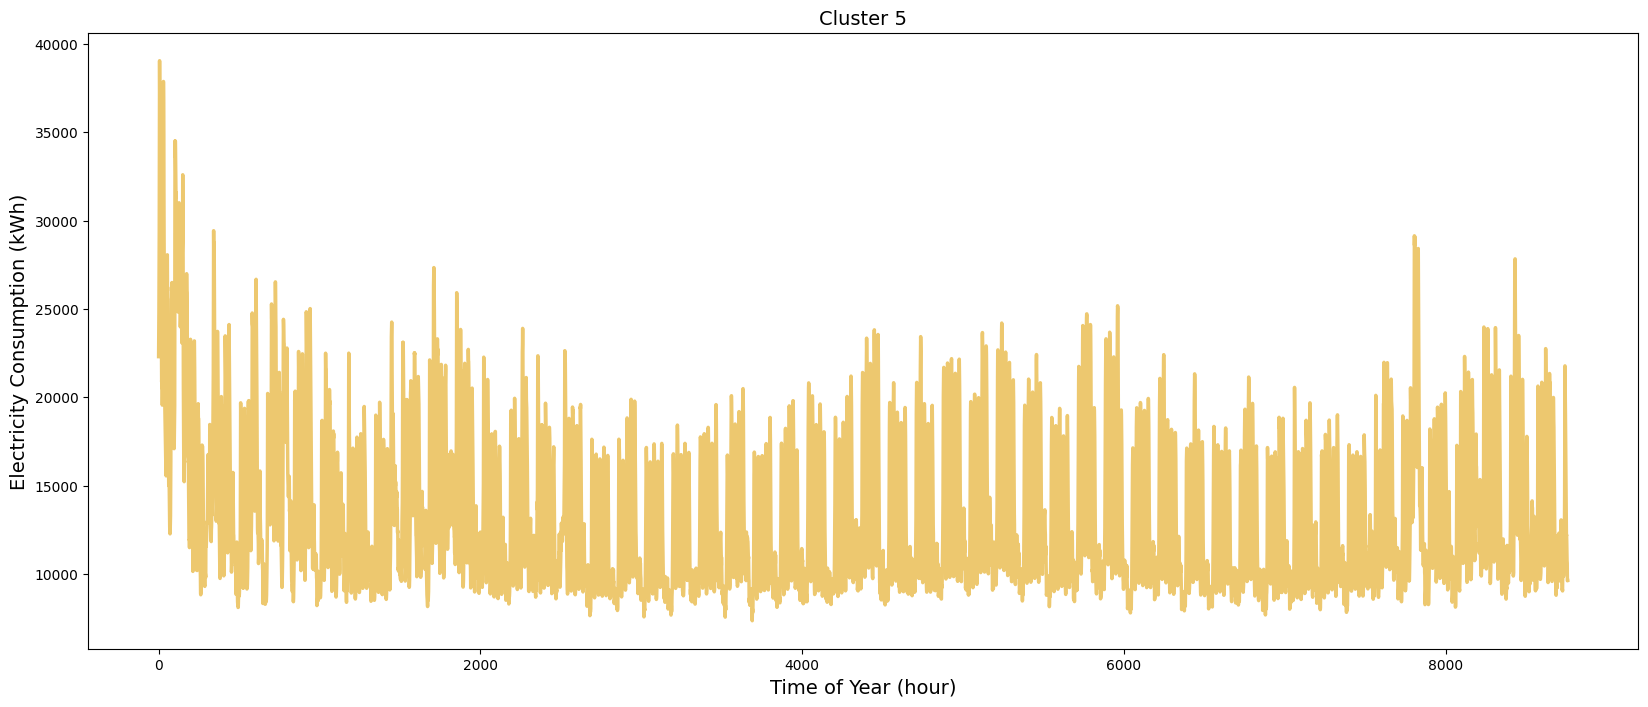

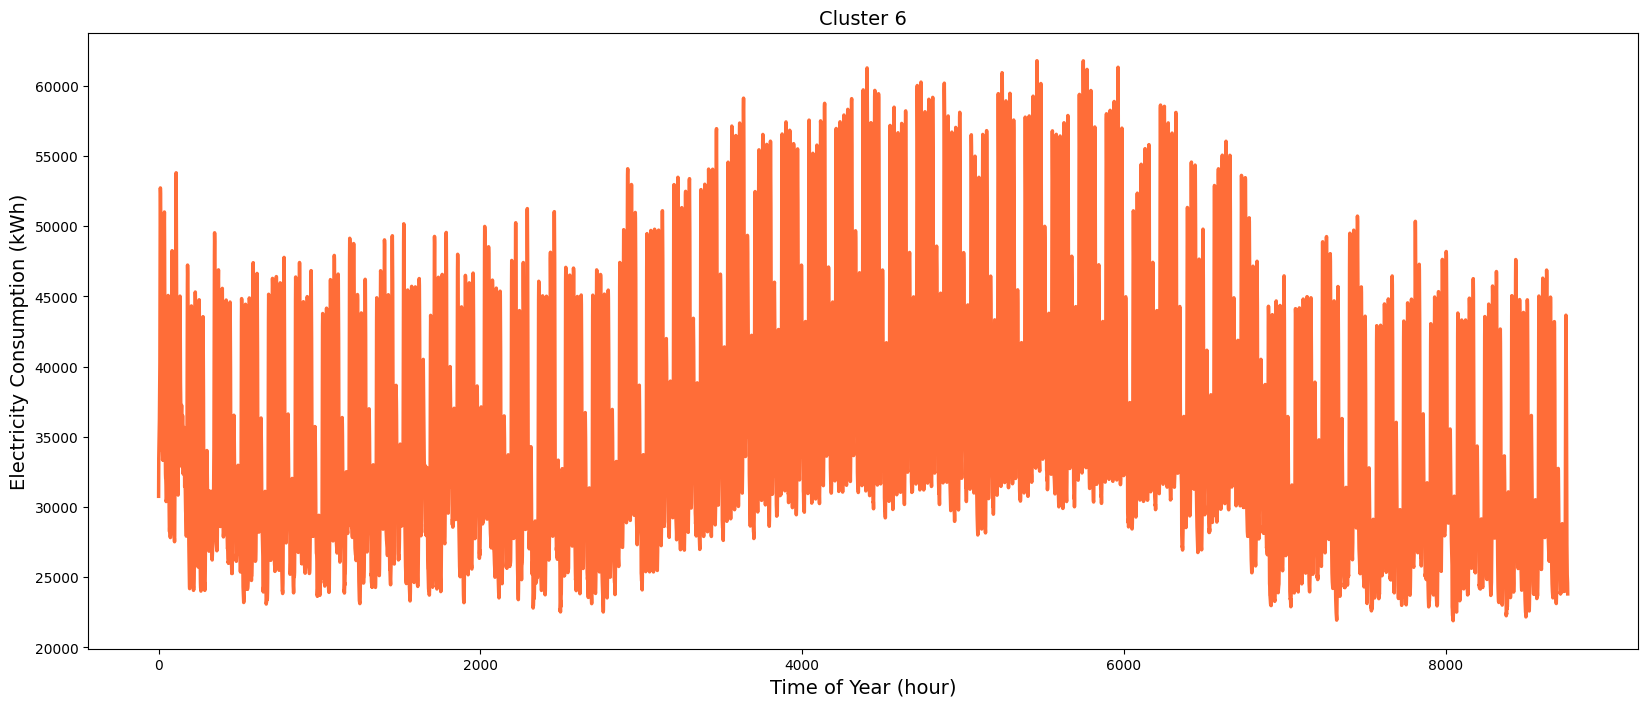

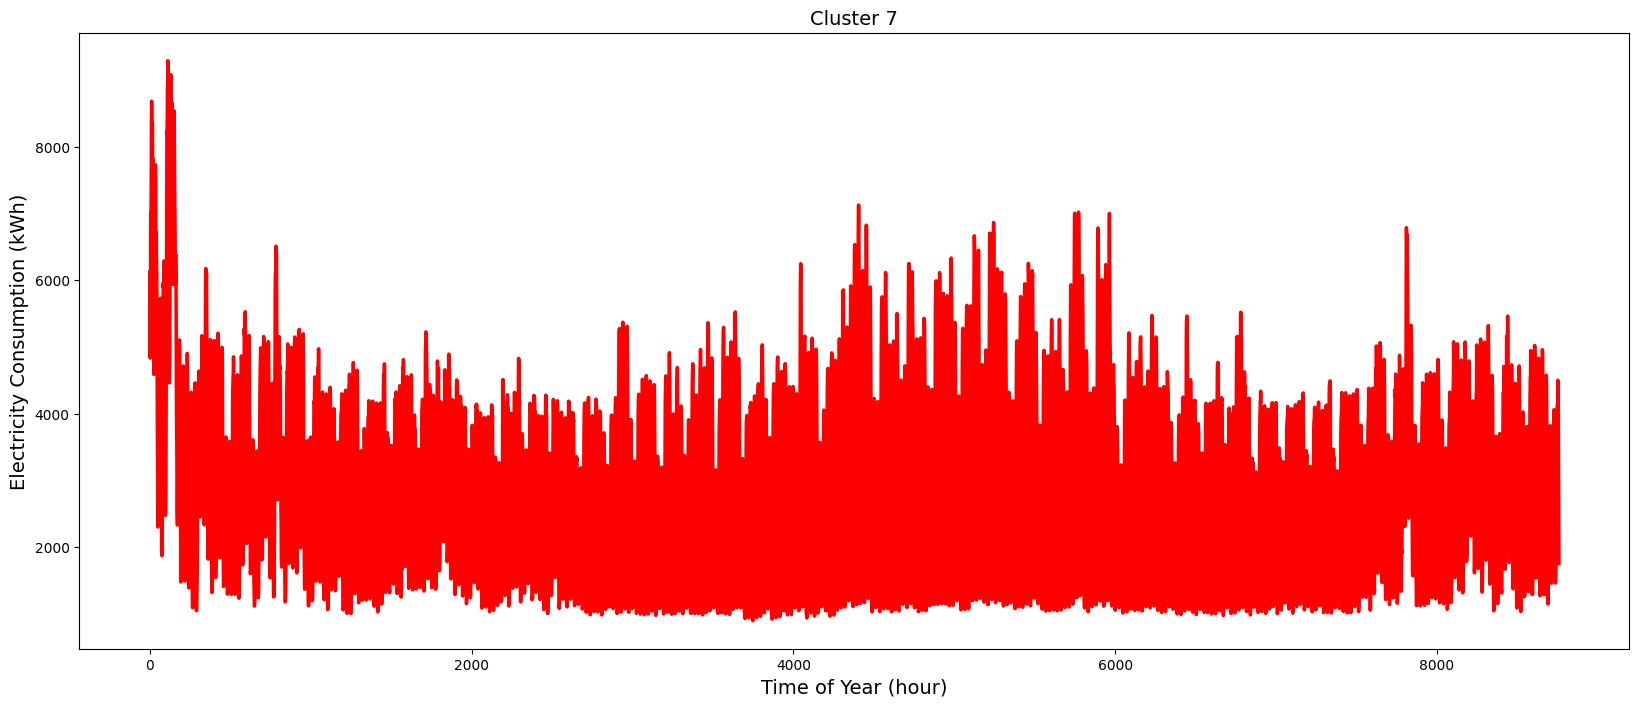

In [20]:
# Plot the total consumption time series for each cluster in the second stage individually
consumptions_array = np.array(consumptions).reshape(1277, 365, 24)
for i in range(8):
    plt.figure(figsize=(20, 8))
    plt.plot(consumptions_array[cluster_labels == i].sum(0).reshape(-1,), color=colors[i], linewidth=2.5)
    plt.xlabel('Time of Year (hour)', fontsize=14)
    plt.ylabel('Electricity Consumption (kWh)', fontsize=14)
    plt.title(f'Cluster {i}', fontsize=14)
    plt.show()

From the first look it is quite clear that some clusters have strong yearly seasonalities while some clusters are quite stable throughout the year. The capacity values of the clusters can be quickly rated at this point. For instance, both cluster 1 and cluster 6 can be very useful for peak curtailment during hot summer days as their consumptions raise a lot during summer. At the same time, the potential of cluster 0, 2, and 5 for curtailment at the beginning of the year is highlighted.

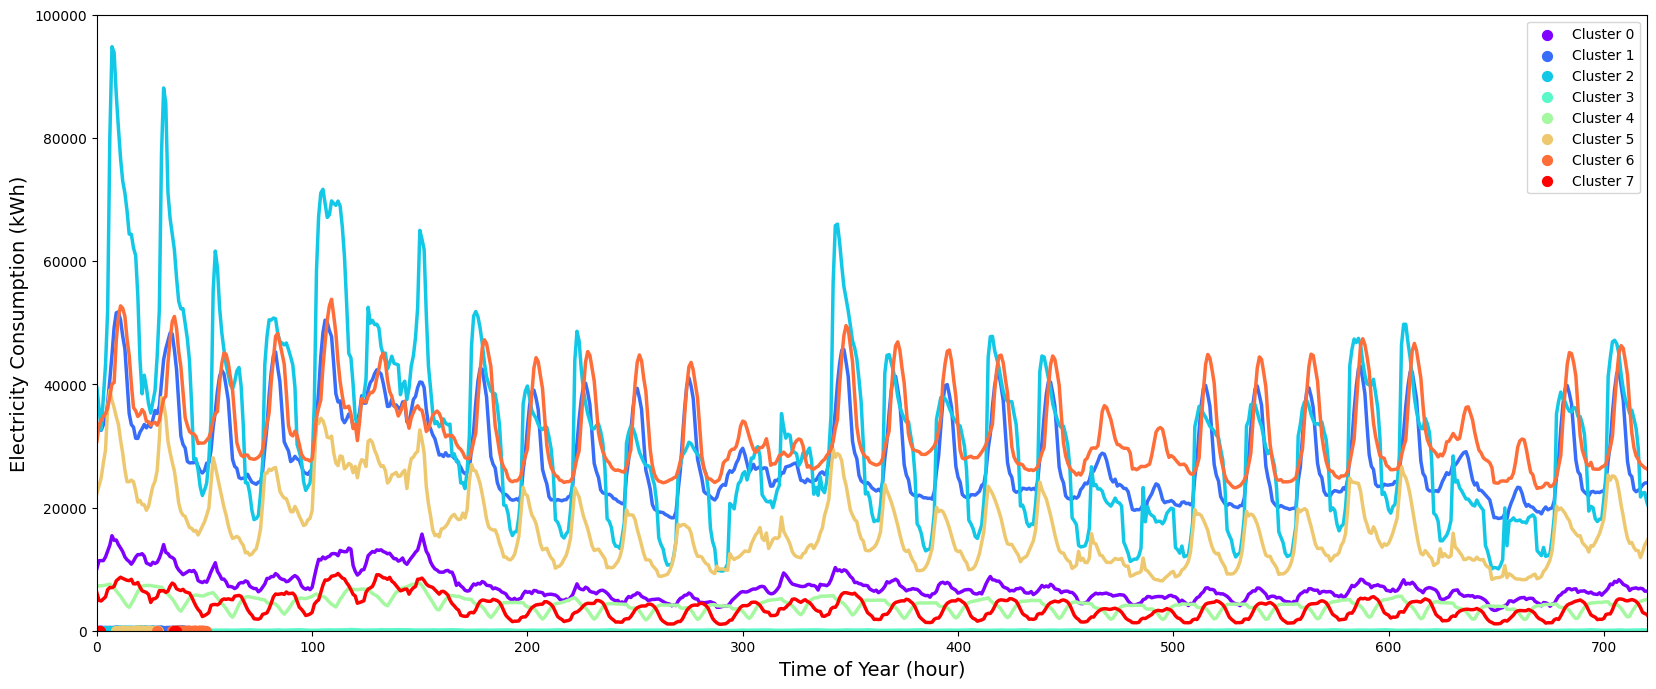

In [21]:
# Plot the aggregate electricity consumption curves of the clusters in the first 30 days of the year
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.plot(consumptions_array[cluster_labels == i].sum(0).reshape(-1,), color=colors[i], linewidth=2.5)
plt.axis([0, 30 * 24, 0, 100000])
plt.xlabel('Time of Year (hour)', fontsize=14)
plt.ylabel('Electricity Consumption (kWh)', fontsize=14)

unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)
plt.legend(loc='best')

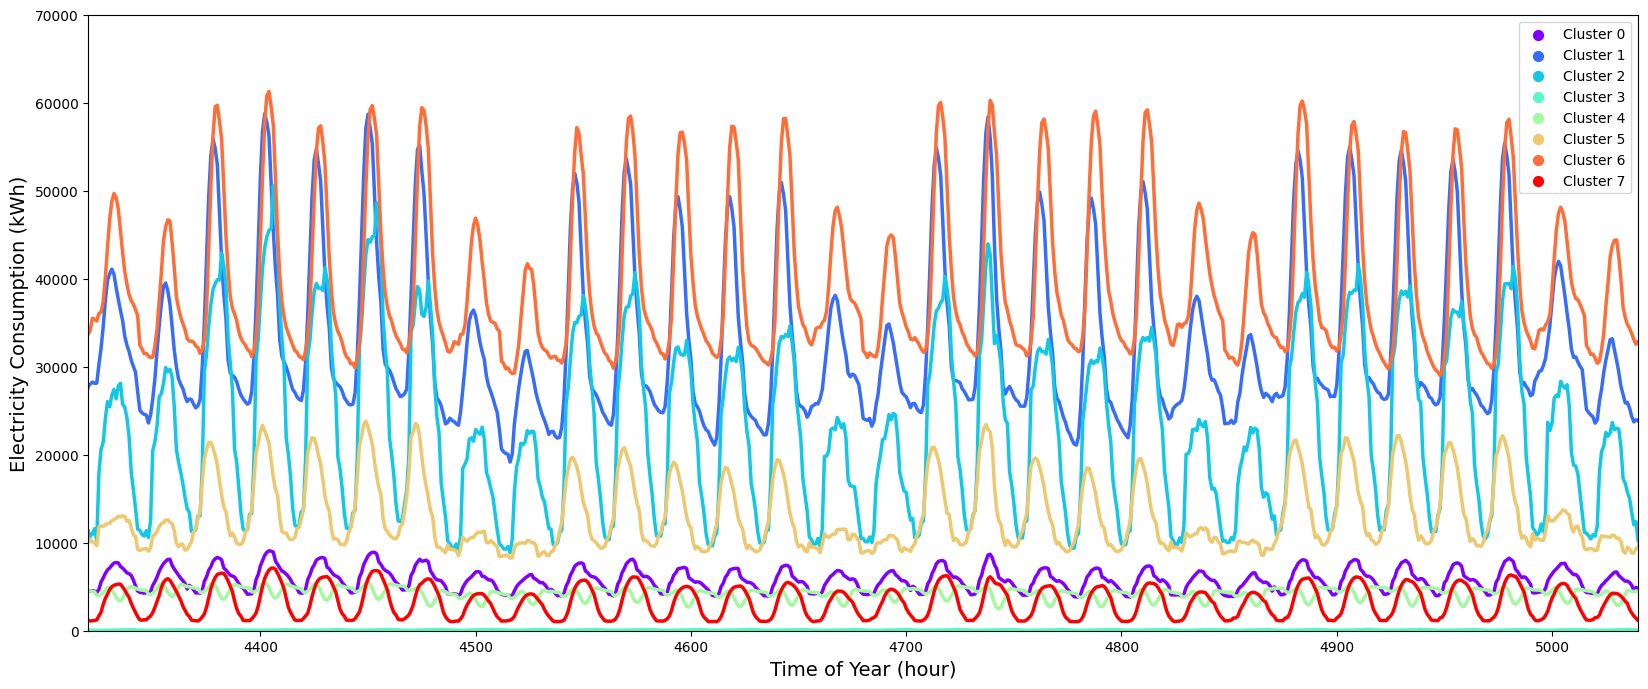

In [22]:
# Plot the aggregate electricity consumption curves of the clusters from the 180th to the 210th days of the year
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.plot(consumptions_array[cluster_labels == i].sum(0).reshape(-1,), color=colors[i], linewidth=2.5)
plt.axis([180 * 24, 180 * 24 + 30 * 24, 0, 70000])
plt.xlabel('Time of Year (hour)', fontsize=14)
plt.ylabel('Electricity Consumption (kWh)', fontsize=14)

unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (cluster_labels == label)
    xy = transformed_data[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, color=[col], label=f'Cluster {label}', zorder=2)
plt.legend(loc='best')

The two graphs above demonstrate the patterns of the clusters in more detail. While differences between clusters are visible, we shall dive deeper into the profiles of the clusters.

In [23]:
# Define the functions for the visualization of each cluster
def plot_cluster(cluster_index):
    profile_cluster = consumptions_array[cluster_labels == cluster_index].sum(axis=0)
    for i in range(len(profile_cluster)):
        plt.plot(profile_cluster[i] / max(profile_cluster[i]), color='k', alpha=0.05)
    plt.plot(profile_cluster.mean(axis=0) / profile_cluster.mean(axis=0).max(), color=colors[cluster_index], linewidth=3)
    plt.xlabel('Time (hour)')
    plt.ylabel('Normalized Electricity Consumption')

def plot_cluster_centroids(cluster_index_list, normalize=False):
    plt.figure(figsize=(14, 6))
    consumptions_array_ = consumptions_array[:, :52*7, :].reshape(1277, 52, 7, 24).reshape(1277, 52, 168)
    for cluster_index in cluster_index_list:
        profile_cluster = consumptions_array_[cluster_labels == cluster_index].sum(axis=0)
        if normalize:
            plt.plot(profile_cluster.mean(axis=0) / profile_cluster.mean(axis=0).max(), color=colors[cluster_index], linewidth=3, label=f'Cluster {cluster_index}')    
            plt.ylabel('Normalized Electricity Consumption')
        else:
            plt.plot(profile_cluster.mean(axis=0), color=colors[cluster_index], linewidth=3, label=f'Cluster {cluster_index}')    
            plt.ylabel('Electricity Consumption (kWh)')
        plt.xlabel('Time (hour)')
        plt.legend(loc='best')

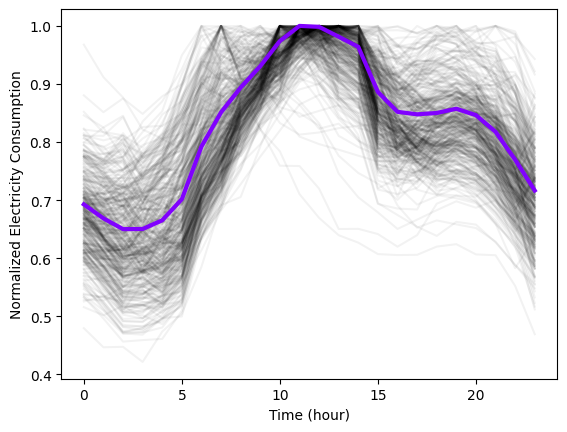

In [24]:
# Cluster 0
cluster_index = 0
plot_cluster(cluster_index)

Cluster 0 is a large cluster (with 535 users) but the total load of this cluster is relatively low.
The shape of the cluster has a major peak near 12:00 and a minor peak near 20:00.
In general, the yearly seasonality of this cluster is not very apparent (except for the rise at the beginning of the year).

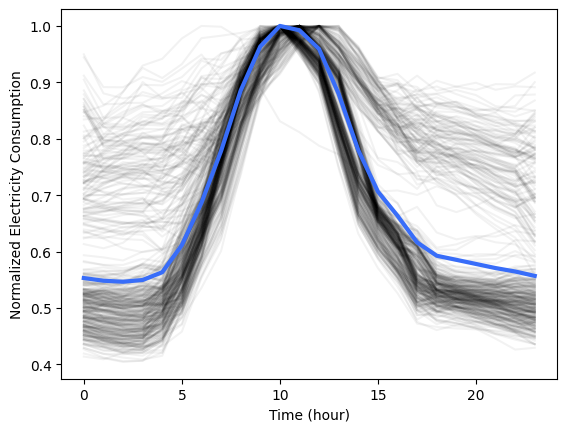

In [25]:
# Cluster 1
cluster_index = 1
plot_cluster(cluster_index)

The peak of cluster 1 is around 10:00. Cluster 1 is an important cluster as its capacity is high.

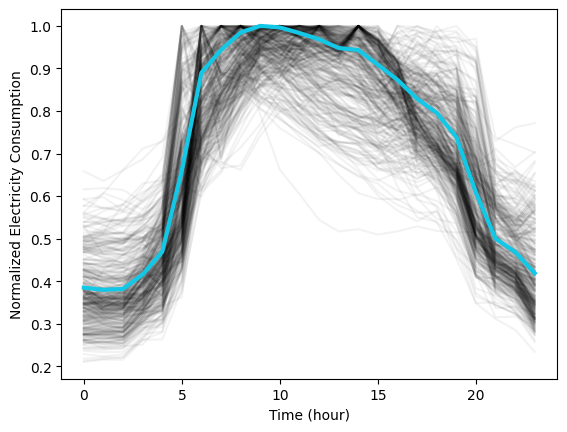

In [26]:
# Cluster 2
cluster_index = 2
plot_cluster(cluster_index)

The peak of cluster 2 is around 9:00, and the shape of the profile is left-skewed. Cluster 2 is important as it has both high capacity and high stability.

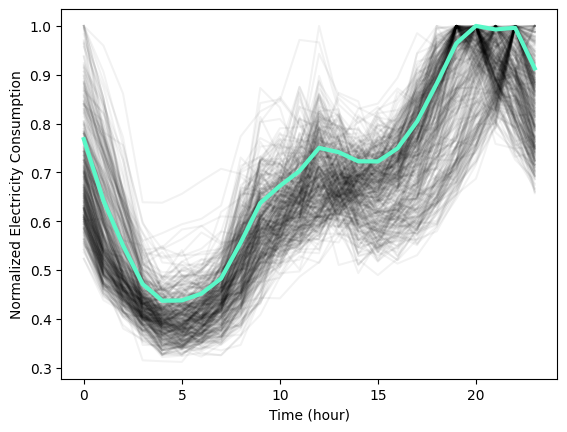

In [27]:
# Cluster 3
cluster_index = 3
plot_cluster(cluster_index)

Cluster 3 is the cluster with the lowest consumption but it actually has a shape as well.

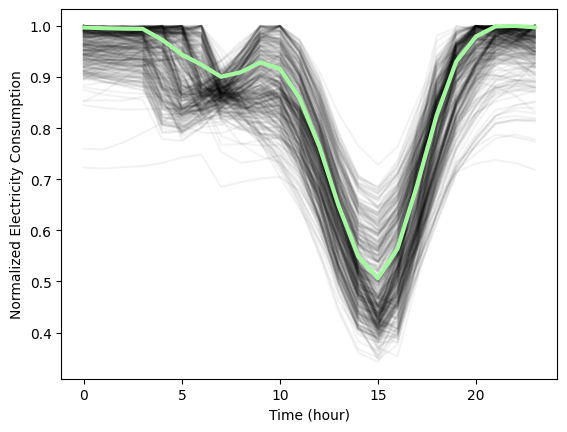

In [28]:
# Cluster 4
cluster_index = 4
plot_cluster(cluster_index)

Cluster 4 is probably the most unique cluster as it has a sharp dip in the afternoon. The lowest point of the mean profile is at 3 o'clock in the afternoon, while some other clusters are at their peaks. In short, this dip in the profile can be very useful for smoothing the load curves during peak hours.

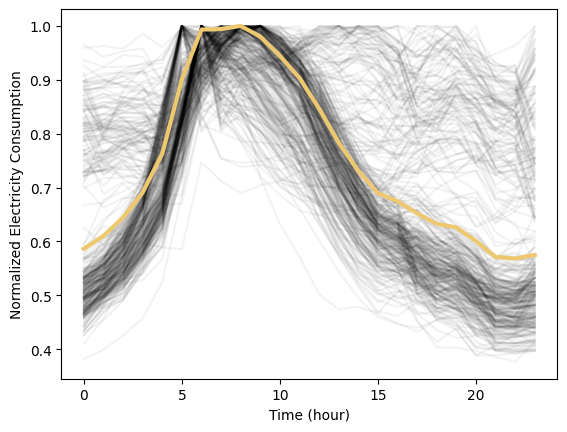

In [29]:
# Cluster 5
cluster_index = 5
plot_cluster(cluster_index)

The peak of cluster 5 is between 6:00 and 8:00, and the left skewness of the profile is visible.
Another major characteristics of this cluster is that the load curves during the weekend is quite flat, which is different from its weekday curves.

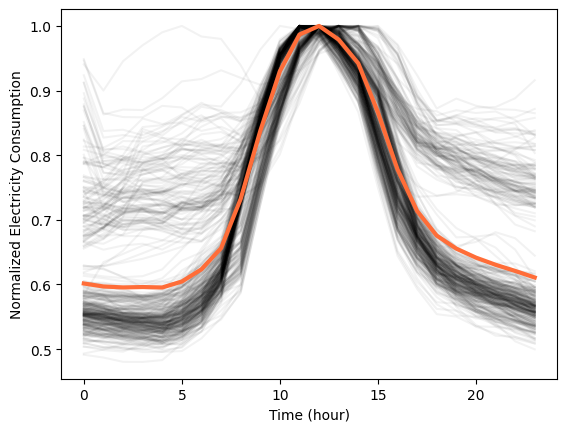

In [30]:
# Cluster 6
cluster_index = 6
plot_cluster(cluster_index)

The peak of cluster 6 is around 12:00. Cluster 6 is the cluster with the highest capacity.
The load curves of this cluster during the weekend also have sharp peaks, but the relative height of the peaks is lower than weekdays.

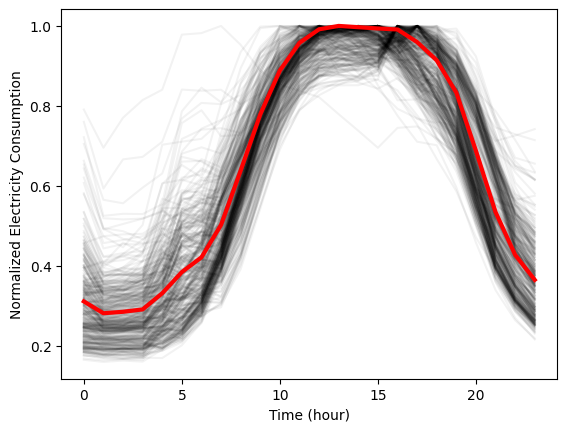

In [31]:
# Cluster 7
cluster_index = 7
plot_cluster(cluster_index)

The peak of cluster 7 is between 12:00 and 16:00. In general, cluster 7 is a very stable cluster.

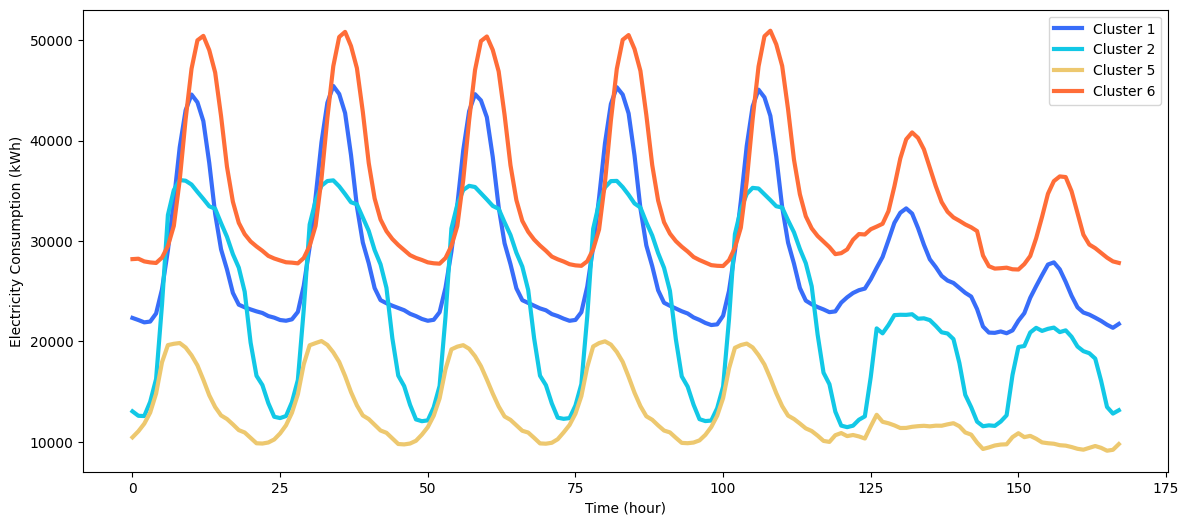

In [32]:
# Next, we put the (weekly) centroids of the clusters with the highest consumptions together, without normalization
plot_cluster_centroids([1, 2, 5, 6])
plt.legend(loc='best')

In the figure above, it is clear that the peaks of the clusters are not aligned, which make all of them unique and useful for demand response programs with particular curtailment targets of different time ranges. Another interesting possiblity of incentive is ask buildings in cluster 5 to shift loads during weekdays to weekends (if possible).

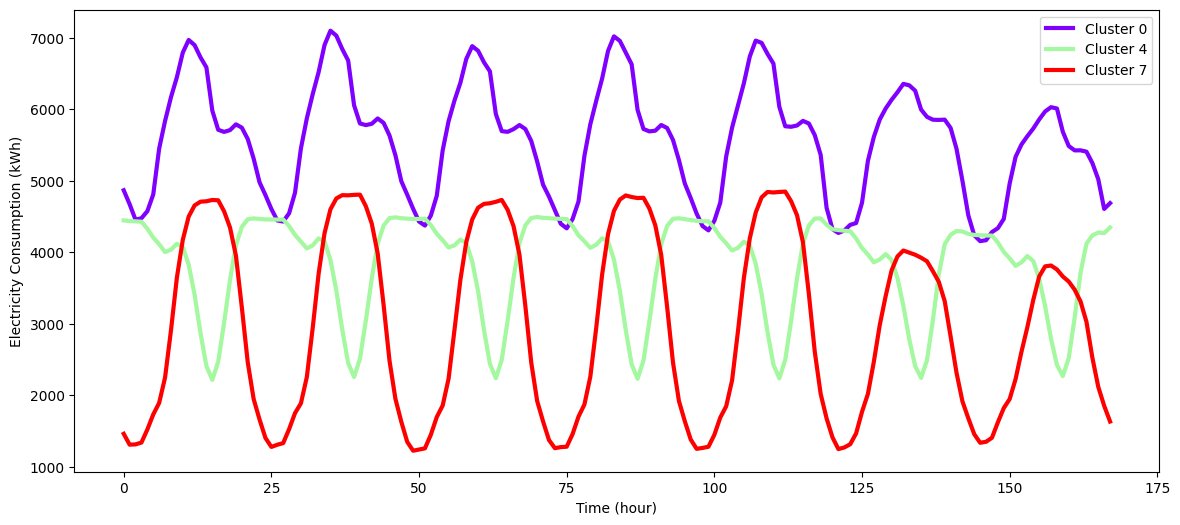

In [33]:
# Next, we put the (weekly) centroids of the clusters with the middle-level consumptions together, without normalization
plot_cluster_centroids([0, 4, 7])
plt.legend(loc='best')

A direct observation here is that cluster 4 is unique in that it has the peak demand at night. We are not sure if this a useful feature for demand response programs but the buildings in this cluster are at least identified in the same group. Cluster 0 can also be important in the evening for its shape. In addition, as we have pointed out that this cluster has a total of 535 customers or buildings within it, the potential of availability value of this cluster is high. Another interesting thing is that these three clusters' loads are more stable throughout the week compared with the four clusters above. Thus, they can be valuable for demand response programs that put much emphasis on stability.

In summary, the proposed clustering method can greatly facilitate demand response programs that align with the electricity consumption patterns of the clusters.

### Further discussions
Here we provide some short discussions covering concerns raised by the host of this challenge.
- Robustness: the proposed method in this notebook is robust to extreme electricity consumption behaviors as only the proportions assgined to each cluster within the four seasons affect the representations of the buildings and hence the final clustering results of stage two.
- Generalizability: the proposed pipelineis naturally generalizable as it does not make assumptions on the exact shapes of the profiles. More specifically, both stages one and two are data-driven, and we only have to feed in the original daily load curves and obtain the results. Note that we do have to set the number of clusters, but the choices are not hard to determine, as shown in the notebook.